# Methods 
This lab will consider snowpack evolution in a maritime snow climate (Oregon) and a continental snowpack (WY) using modeling. A first step in employing a model over new spatial domains is model calibration. Toward informing the calibration process, this lab will explore the sensitivity of SnowModel, a spatially distributed snow-evolution model, to multiple parameters. A Monte Carlo simulation will be employed to quantify the uncertainty associated with the parameters to which the model is most sensitive. This lab will consider snowpack evolution at points that coincide with SNOTEL station locations in OR and WY to help guide calibration decisions for larger modeling domains.
### SnowModel (Liston, G. E and Elder, K. 2006)
Glen Liston developed SnowModel (SM) in 2006 to model snow regimes across a range of climates and locations. SnowModel is a spatially distributed snow-evolution modeling system that incorporates four submodels: MicroMet, EnBal, SnowPack, and SnowTran-3D. MicroMet is a quasi-physically based meteorological model used to define meteorological forcing conditions. EnBal calculates surface energy balance. SnowPack is a single- or multi-layer snowpack evolution model that simulates the evolution of snow depth and snow water equivalent.  SnowTran-3D is a three-dimensional model that simulates snow-depth change driven by wind.  SnowAssim, can be used with SM to assimilate ground-based and remotely sensed snow data to constrain and improve SM outputs.
![](Figs/SM.png)
Model state variables include sub-daily meteorological data: precipitation, relative humidity, temperature, wind speed wind direction, and surface pressure. Optional meteorological data used in these simulations include incoming shortwave and longwave radiation. Additional model inputs include elevation and land-cover data. While there are multiple hydrological output variables from SnowModel, the daily hydrological outputs evaluated in this report are SWE and snow melt (water released from the snowpack). SM is run for 360 days starting on October 1, 2018.

**Data:**

Parameter | Source | Resolution 
--------- | ---------- | -----
Meteorological data | NCEP Climate Forecast System Version 2 (Saha et al. 2013)| 0.2 degrees, 6-hourly
Landcover data | USGS National Land Cover Database (Yang et al. 2018)| 30 m
Digital elevation model | Shuttle Radar Topography Mission (Farr et al. 2007)| 30 m

## Sensitivity analysis
SM starts with the base parameters of `ro_snowmax `, `ro_adjust`, `pcor`, and `gap_frac`. First, SM is run with the base parameters. The sensitivity response variables considered in this lab include maximum SWE `swe_mx`, number of snow covered days `swe_days`, and cumulative water released from the snowpack `swe_mlt` in response to perturbations to the four sensitivity parameters. 

Second, the base parameters will be perturbed in order to calculate sensitivity statistics of relative sensitivity and absolute sensitivity. We will perturb parameters selected for sensitivity analysis by 10% and rerun the model.

The two sensitivity statistics that are calculated are relative sensitivity and absolute sensitivity:
 
$$ \large Absolute Sensitivity = \frac{R_p-R_b}{P_p-P_b} $$

$$ \large Relative Sensitivity = \frac {\frac {R_p-R_b}{R_b}} {\frac {P_p-P_b}{P_b}} $$

where:
$ R_b $ is the base Response value

$ R_p $ is the perturbed Response value

$ P_b $ is the base Parameter value

$ P_b $ is the pertured Parameter value

**Sensitivy Analysis Parameters:**

Parameter | Definition | Base Value
--------- | ---------- | -----
`ro_snowmax` | Maximum snow density threshold | 550.0 kg m$^{-3}$
`ro_adjust` | Snow density adjustment factor (>1 = faster density increase, <1 = slower density increase) | 5.0
`pcor` | Precipitation correction factor (>1 = increase precipitation, <1 = decrease precipitation)| 1.0
`gap_frac` | Canopy gap fraction (0-1) | 0.02

Third, a local sensitivity is used to evaluate sensitivity of the response across many values of `ro_snowmax` and `pcor`. Local sensitivity is defined by:

$$ S_{local} = \left| \frac{\partial Y}{\partial X} \right|_{X_{0}} $$

This is the partial derivative of the response taken at a specific location ($X_0$)

In [1]:
## Model setup

# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osgeo
from osgeo import gdal
from shapely import geometry as sgeom
import osr
import xarray
import ulmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
from scipy.stats import norm

#model filename
parFile = "sm/snowmodel.par"
codeFile = "sm/code/snowpack_code.f"
metcodeFile = "sm/code/micromet_code.f"
PcorFile = "sm/precip_cf/cf_precip.dat"
ctlFile = 'sm/ctl_files/wo_assim/swed.ctl'
sweFile = 'sm/outputs/wo_assim/swed.gdat'
roffFile = 'sm/outputs/wo_assim/roff.gdat'
spreFile = 'sm/outputs/wo_assim/spre.gdat'
smltFile = 'sm/outputs/wo_assim/smlt.gdat'
precFile = 'sm/outputs/wo_assim/prec.gdat'
rpreFile = 'sm/outputs/wo_assim/rpre.gdat'
tairFile = 'sm/outputs/wo_assim/tair.gdat'


In [ ]:
# ##Gather relevant SNOTEL station data within your modeling domain

# #This is done once
# #Get the SNOTEL data and save into shapefile for later use - 
# #this is done once

# #function to extract SNOTEL data
# def sites_asgdf(ulmo_getsites, crs='epsg:4326'):
#     """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
#     """    
#     # Note: Found one SNOTEL site that was missing the location key
#     sites_df = pd.DataFrame.from_records([
#         OrderedDict(code=s['code'], 
#         longitude=float(s['location']['longitude']), 
#         latitude=float(s['location']['latitude']), 
#         name=s['name'], 
#         elevation=s['elevation_m'])
#         for _,s in ulmo_getsites.items()
#         if 'location' in s
#     ])
#     sites_gdf = gpd.GeoDataFrame(
#         sites_df, 
#         geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
#         crs=crs
#     )
#     return sites_gdf

# def get_stn_gdf(Bbox, mod_proj):
#     # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
#     box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
#     box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs='epsg:4326')

#     # WaterML/WOF WSDL endpoint url 
#     wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

#     # get dictionary of snotel sites 
#     sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#     #SNOTEL sites as geodataframe 
#     snotel_gdf = sites_asgdf(sites)

#     #create gdf for SNOTEL metadata within bounding box
#     stn_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
#     stn_gdf.drop(columns='index_right', inplace=True)
#     #reset inex
#     stn_gdf.index = range(len(stn_gdf.index))

#     #add columns with projected coordinates 
#     stn_proj = stn_gdf.to_crs({'init' :mod_proj})
#     stn_gdf['lon_proj'] = stn_proj.geometry.x
#     stn_gdf['lat_proj'] = stn_proj.geometry.y
#     return stn_gdf

# #WY station
# Bbox = {'latmax' : (43.516869 + 0.001),'latmin' : (43.516869 - 0.001),'lonmax': (-110.912582 + 0.001),'lonmin': (-110.912582 - 0.001),}
# station_gdf = get_stn_gdf(Bbox,'epsg:32612')
# #station_gdf.to_file("WY_station.shp")

# #OR station
# Bbox = {'latmax' : (45.4287 + 0.001),'latmin' : (45.4287 - 0.001),'lonmax': (-121.85605 + 0.001),'lonmin': (-121.85605 - 0.001),}  
# station_gdf = get_stn_gdf(Bbox,'epsg:32610')
# #station_gdf.to_file("OR_station.shp")

In [2]:
## Build functions to edit the parameter text file and 
#define a spatial domain (OR or WY)

#function to edit .par file
FileName = "sm/snowmodel.par"

def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

#function to set modeling domain
def set_domain(domain):
    if domain == 'WY':
        replace_line(parFile, 31, '      nx = 3\n')
        replace_line(parFile, 32, '      ny = 3\n')
        replace_line(parFile, 48, '      xmn = 506900.00\n')
        replace_line(parFile, 49, '      ymn = 4818100.00\n')
        replace_line(parFile, 120, '      met_input_fname = ../GEEw/mm_wy_2018-2019.dat\n')
        replace_line(parFile, 148, '      topo_ascii_fname = ../GEEw/DEM_WY.asc\n')
        replace_line(parFile, 149, '      veg_ascii_fname = ../GEEw/NLCD2016_WY.asc\n')
        replace_line(parFile, 249, '      xlat = 43.5\n')
        replace_line(metcodeFile, 3020, "      if (iter.eq.1) open (unit=71,file='../GEEw/shortwave.dat')\n")
        replace_line(metcodeFile, 3100, "      if (iter.eq.1) open (unit=72,file='../GEEw/longwave.dat')\n")        
        mod_proj = 'epsg:32612' #UTM zone 12N
        Bbox = {
            'latmax' : (43.516869 + 0.001),
            'latmin' : (43.516869 - 0.001),
            'lonmax': (-110.912582 + 0.001),
            'lonmin': (-110.912582 - 0.001),}     
        stn_gdf = gpd.read_file("WY_station.shp")
        print('You in WY!')
        return mod_proj , Bbox, stn_gdf
    elif domain == 'OR':
        replace_line(parFile, 31, '      nx = 4\n')
        replace_line(parFile, 32, '      ny = 4\n')       
        replace_line(parFile, 48, '      xmn = 589400.00\n')
        replace_line(parFile, 49, '      ymn = 5031000.00\n')
        replace_line(parFile, 120, '      met_input_fname = ../GEEo/mm_or_2018-2019.dat\n')
        replace_line(parFile, 148, '      topo_ascii_fname = ../GEEo/DEM_OR.asc\n')
        replace_line(parFile, 149, '      veg_ascii_fname = ../GEEo/NLCD2016_OR.asc\n')
        replace_line(parFile, 249, '      xlat = 45.4\n')  
        replace_line(metcodeFile, 3020, "      if (iter.eq.1) open (unit=71,file='../GEEo/shortwave.dat')\n")
        replace_line(metcodeFile, 3100, "      if (iter.eq.1) open (unit=72,file='../GEEo/longwave.dat')\n") 
        mod_proj = 'epsg:32610' #UTM zone 10N
        Bbox = {
            'latmax' : (45.4287 + 0.001),
            'latmin' : (45.4287 - 0.001),
            'lonmax': (-121.85605 + 0.001),
            'lonmin': (-121.85605 - 0.001),}  
        stn_gdf = gpd.read_file("OR_station.shp")
        print('You in OR!')
        return mod_proj , Bbox, stn_gdf
    else:
        print('Domain not defined')

In [3]:
## Build a function to compile and execute SnowModel in terminal 
#from the Jupyter Notebook. 

def runSnowModel():
    %cd /Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code/
    #run compile script 
    ! nohup ./compile_snowmodel.script
    #run SnowModel
    %cd /Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/
    ! nohup ./snowmodel
    %cd /Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

In [ ]:
# ##Determine the i,j pair where the SNOTEL station is located 
# #in the SM output. 

# # #Do this once after baseline runs for OR and WY
# #This will allow you to extract hydrological output variables 
# #at the correct location. 

# ## Execute baseline runs for each domain
# mod_proj, Bbox, stn_gdf = set_domain('WY')
# nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();

# #Build lat/lon array 
# #Longitudes
# ln = np.arange(xll, xll+nx*clsz, clsz)
# #Latitudes
# lt = np.arange(yll, yll+ny*clsz, clsz)

# def get_stn_idx(stn_gdf):
#     #get index for each SNOTEL station relative to the SnowModel output
#     lon_idx = np.empty(stn_gdf.shape[0])
#     lat_idx = np.empty(stn_gdf.shape[0])
#     for z in range(stn_gdf.shape[0]):
#         lons = abs(stn_gdf.lon_proj[z]-ln)
#         loIDX = [i for i, value in enumerate(lons) if value == np.min(abs(stn_gdf.lon_proj[z]-ln))] 
#         lon_idx[z] = loIDX[0]
#         lats = abs(stn_gdf.lat_proj[z]-lt)
#         laIDX = [i for i, value in enumerate(lats) if value == np.min(abs(stn_gdf.lat_proj[z]-lt))]
#         lat_idx[z] = laIDX[0]
#     stn_gdf['lat_idx'] = lat_idx
#     stn_gdf['lon_idx'] = lon_idx
#     return stn_gdf

# stn_gdf = get_stn_idx(stngdf)
# stn_gdf.to_file("WY_station.shp")

In [4]:
## Build a function to convert the binary model output 
#.gdat file to a xarray

def get_mod_output(inFile,stn_gdf):
    # #Build lat/lon array 
    # #Longitudes
    ln = np.arange(xll, xll+nx*clsz, clsz)
    # #Latitudes
    lt = np.arange(yll, yll+ny*clsz, clsz)

    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data 
    numpy_data = np.reshape(numpy_data,(num_sim_days,ny,nx))
    # numpy SWE to xarray
    xarray_data = xarray.DataArray(numpy_data,dims=('time','lat','lon'), 
                            coords={'time':pd.date_range(st, periods=num_sim_days),
                                    'lat':lt,'lon':ln})
    #swe only at station point
    data = np.squeeze(xarray_data[:,int(stn_gdf.lat_idx[0]),int(stn_gdf.lon_idx[0])].values)

    return data

In [5]:
## Build functions to edit the SnowModel code to adjust the 
#parameters to be explored in the sensitivity analysis
def change_rhomx(rho):
    insert = '{:.1f}'.format(rho)
    replace_line(codeFile, 916, '      ro_snowmax = '+insert+'\n')
    
def change_rho_adj(rho):
    insert = '{:.1f}'.format(rho)
    replace_line(codeFile, 771, '      ro_adjust = '+insert+'\n')
    
def change_pcor(on,value):
    insert = '{:.1f}'.format(on)
    replace_line(parFile, 680, '      cf_precip_flag = '+insert+'\n')
    insert2 = '{:.3f}'.format(value)
    replace_line(PcorFile, 0, ' '+insert2+'\n')
    
def change_gap(value):
    insert = '{:.3f}'.format(value)
    replace_line(parFile, 633, '      gap_frac = '+insert+'\n')
    
def change_veg_shd(value):
    insert = '{:.2f}'.format(value)
    replace_line(parFile, 208, '      veg_shd_25 = '+insert+'\n')
    replace_line(parFile, 209, '      veg_shd_26 = '+insert+'\n')
    replace_line(parFile, 210, '      veg_shd_27 = '+insert+'\n')
    replace_line(parFile, 211, '      veg_shd_28 = '+insert+'\n')
    replace_line(parFile, 212, '      veg_shd_29 = '+insert+'\n')
    replace_line(parFile, 213, '      veg_shd_30 = '+insert+'\n')

#only 0 or 1    
def change_snowtran(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 301, '      run_snowtran = '+insert+'\n')

def change_curvelen(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 520, '      curve_len_scale = '+insert+'\n')

#only 0 or 1     
def change_lapse(value):
    insert = '{:.0f}'.format(value)
    replace_line(parFile, 564, '      lapse_rate_user_flag = '+insert+'\n') 
    
#only 0 or 1     
def change_prec_lapse(value):
    insert = '{:.0f}'.format(value)
    replace_line(parFile, 574, '      iprecip_lapse_rate_user_flag = '+insert+'\n')    
    
#only 1.0, 2.0, or 3.0  
def change_snow_frac(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 598, '      snowfall_frac = '+insert+'\n')  

def change_wind_lapse(value):
    insert = '{:.3f}'.format(value)
    replace_line(parFile, 614, '      wind_lapse_rate = '+insert+'\n')   
    
def change_cloud_frac(value):
    insert = '{:.2f}'.format(value)
    replace_line(parFile, 645, '      cloud_frac_factor = '+insert+'\n')
    
def change_shortwave(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 653, '      use_shortwave_obs = '+insert+'\n')

def change_longwave(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 661, '      use_longwave_obs = '+insert+'\n')
    
def change_slope_adjust(value):
    insert = '{:.3f}'.format(value)
    replace_line(parFile, 758, '      slope_adjust = '+insert+'\n')

def change_ro_snow(value):
    insert = '{:.1f}'.format(value)
    replace_line(parFile, 786, '      ro_snow = '+insert+'\n')
    
def change_albedo_forest(value):
    insert = '{:.2f}'.format(value)
    replace_line(parFile, 819, '      albedo_snow_forest = '+insert+'\n')

def change_albedo_clear(value):
    insert = '{:.2f}'.format(value)
    replace_line(parFile, 826, '      albedo_snow_clearing = '+insert+'\n')    

    

In [6]:
## Build function to get the max SWE, snow days, and cumulative melt
# sensitivity variables

def getSensitivityVals():
    SWE = get_mod_output(sweFile,stn_gdf)
    swe_mx = np.max(SWE)
    swe_days = sum(SWE>0)
    SMLT = get_mod_output(smltFile,stn_gdf)
    swe_mlt = cumsum(SMLT)[-1]
    return swe_mx, swe_days, swe_mlt

In [7]:
def Sensitive(Rb,name,Rp,base):
    absSensitivity = (Rp-Rb)/(rescaleValue*base)   
    relSensitivity = ((Rp-Rb)/Rb)/rescaleValue
    results = (name,base,base*(1+.1),Rp,absSensitivity,relSensitivity)
    return results


In [42]:
## Sensitivity analysis
# Perturb parameters selected for sensitivity analysis 
#by 10% and rerun the model.

#select domain
mod_proj, Bbox, stn_gdf = set_domain('WY')

#10% purturbation 
rescaleValue = 0.10 

# store base case parameter values
rho_mx_base = 550.0
rho_adj_base = 5.0
pcor_base = [0.0,1.0]
gap_frac_base = 0.02
veg_shd_base = 0.10
snowtran_base = 0.0
curvelen_base = 500.0
lapse_base = 0
prec_lapse_base = 0
snow_frac_base = 3.0
wind_lapse_base = 0.0
cloud_frac_base = 1.0
shortwave_base = 0.0
longwave_base = 0.0
slope_adjust_base = 1.0
ro_snow_base = 300.0
albedo_forest_base = 0.45
albedo_clear_base = 0.6

# run the base case
change_rhomx(rho_mx_base)
change_rho_adj(rho_adj_base)
change_pcor(pcor_base[0],pcor_base[1])
change_gap(gap_frac_base)
change_veg_shd(veg_shd_base)
change_snowtran(snowtran_base)
change_curvelen(curvelen_base)
change_lapse(lapse_base )
change_prec_lapse(prec_lapse_base )
change_snow_frac(snow_frac_base )
change_wind_lapse(wind_lapse_base) 
change_cloud_frac(cloud_frac_base )
change_shortwave(shortwave_base )
change_longwave(longwave_base) 
change_slope_adjust(slope_adjust_base) 
change_ro_snow(ro_snow_base )
change_albedo_forest(albedo_forest_base )
change_albedo_clear(albedo_clear_base)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxB, swe_daysB, swe_mltB = getSensitivityVals()
print(swe_mxB, swe_daysB, swe_mltB)

# perturb rho_mx parameter
inval = rho_mx_base * (1+rescaleValue)    # perturb by 10 percent
change_rhomx(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxRX, swe_daysRX, swe_mltRX = getSensitivityVals()
print(swe_mxRX, swe_daysRX, swe_mltRX)
change_rhomx(rho_mx_base) #change back to base value

# perturb rho_adj parameter 
inval = rho_adj_base * (1+rescaleValue)    # perturb by 10 percent
change_rho_adj(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxRA, swe_daysRA, swe_mltRA = getSensitivityVals()
print(swe_mxRA, swe_daysRA, swe_mltRA)
change_rho_adj(rho_adj_base)

# perturb Pcor parameter
inval = pcor_base[1] * (1+rescaleValue)    # perturb by 10 percent
change_pcor(3.0,inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxP, swe_daysP, swe_mltP = getSensitivityVals()
print(swe_mxP, swe_daysP, swe_mltP)
change_pcor(pcor_base[0],pcor_base[1])

# perturb gap_frac parameter
inval = gap_frac_base * (1+rescaleValue)    # perturb by 10 percent
change_gap(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxG, swe_daysG, swe_mltG = getSensitivityVals()
print(swe_mxG, swe_daysG, swe_mltG)
change_gap(gap_frac_base)

# perturb veg_shd parameter
inval = veg_shd_base * (1+rescaleValue)    # perturb by 10 percent
change_veg_shd(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxVS, swe_daysVS, swe_mltVS = getSensitivityVals()
print(swe_mxVS, swe_daysVS, swe_mltVS)
change_veg_shd(veg_shd_base)

# turn snowtran parameter on
inval = 1.0
change_snowtran(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxT, swe_daysT, swe_mltT = getSensitivityVals()
print(swe_mxT, swe_daysT, swe_mltT)
change_snowtran(snowtran_base)

# perturb curvelen parameter
inval = curvelen_base * (1+rescaleValue)    # perturb by 10 percent
change_curvelen(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxC, swe_daysC, swe_mltC = getSensitivityVals()
print(swe_mxC, swe_daysC, swe_mltC)
change_curvelen(curvelen_base)

# perturb lapse parameter
inval = 1  # perturb by 10 percent
change_lapse(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxL, swe_daysL, swe_mltL = getSensitivityVals()
print(swe_mxL, swe_daysL, swe_mltL)
change_lapse(lapse_base)

# perturb prec_lapse parameter
inval = 1   # perturb by 10 percent
change_prec_lapse(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxPL, swe_daysPL, swe_mltPL = getSensitivityVals()
print(swe_mxPL, swe_daysPL, swe_mltPL)
change_prec_lapse(prec_lapse_base)  
    
# change snow_frac physics1
inval = 1.0
change_snow_frac(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxSF1, swe_daysSF1, swe_mltSF1 = getSensitivityVals()
print(swe_mxSF1, swe_daysSF1, swe_mltSF1)
change_snow_frac(snow_frac_base)

 # change snow_frac physics2
inval = 2.0
change_snow_frac(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxSF2, swe_daysSF2, swe_mltSF2 = getSensitivityVals()
print(swe_mxSF2, swe_daysSF2, swe_mltSF2)
change_snow_frac(snow_frac_base)

# perturb wind_lapse parameter
inval = wind_lapse_base * (1+rescaleValue)    # perturb by 10 percent
change_wind_lapse(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxWL, swe_daysWL, swe_mltWL = getSensitivityVals()
print(swe_mxWL, swe_daysWL, swe_mltWL)
change_wind_lapse(wind_lapse_base)     

# perturb cloud_frac parameter
inval = cloud_frac_base * (1+rescaleValue)    # perturb by 10 percent
change_cloud_frac(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxCF, swe_daysCF, swe_mltCF = getSensitivityVals()
print(swe_mxCF, swe_daysCF, swe_mltCF)
change_cloud_frac(cloud_frac_base)   

# perturb shortwave parameter
inval = 1.0
change_shortwave(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxSW, swe_daysSW, swe_mltSW = getSensitivityVals()
print(swe_mxSW, swe_daysSW, swe_mltSW)
change_shortwave(shortwave_base)

# perturb longwave parameter
inval = 1.0
change_longwave(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxLW, swe_daysLW, swe_mltLW = getSensitivityVals()
print(swe_mxLW, swe_daysLW, swe_mltLW)
change_longwave(longwave_base)
    
# perturb slope_adjust parameter
inval = slope_adjust_base * (1+rescaleValue)    # perturb by 10 percent
change_slope_adjust(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxSA, swe_daysSA, swe_mltSA = getSensitivityVals()
print(swe_mxSA, swe_daysSA, swe_mltSA)
change_slope_adjust(slope_adjust_base)

# perturb ro_snow parameter
inval = ro_snow_base * (1+rescaleValue)    # perturb by 10 percent
change_ro_snow(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxRS, swe_daysRS, swe_mltRS = getSensitivityVals()
print(swe_mxRS, swe_daysRS, swe_mltRS)
change_ro_snow(ro_snow_base)
    
# perturb albedo_forest parameter
inval = albedo_forest_base * (1+rescaleValue)    # perturb by 10 percent
change_albedo_forest(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxAF, swe_daysAF, swe_mltAF = getSensitivityVals()
print(swe_mxAF, swe_daysAF, swe_mltAF)
change_albedo_forest(albedo_forest_base)

# perturb albedo_clear parameter
inval = albedo_clear_base * (1+rescaleValue)    # perturb by 10 percent
change_albedo_clear(inval)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxAC, swe_daysAC, swe_mltAC = getSensitivityVals()
print(swe_mxAC, swe_daysAC, swe_mltAC)
change_albedo_clear(albedo_clear_base)    

You in WY!
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final
0.95690656 278 1.4760494
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final
0.99097365 283 1.6079195
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final
0.9495309 278 1.4656978
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2

In [48]:
## Sensitivity analysis
# Perturb parameters selected for sensitivity analysis 
#by 10% and rerun the model.

#select domain
mod_proj, Bbox, stn_gdf = set_domain('OR')

#10% purturbation 
rescaleValue = 0.10 

# store base case parameter values
rho_mx_base = 550.0
rho_adj_base = 5.0
pcor_base = [0.0,1.0]
gap_frac_base = 0.02
veg_shd_base = 0.10
snowtran_base = 0.0
curvelen_base = 500.0
lapse_base = 0
prec_lapse_base = 0
snow_frac_base = 3.0
wind_lapse_base = 0.0
cloud_frac_base = 1.0
shortwave_base = 0.0
longwave_base = 0.0
slope_adjust_base = 1.0
ro_snow_base = 300.0
albedo_forest_base = 0.45
albedo_clear_base = 0.6

# run the base case
change_rhomx(rho_mx_base)
change_rho_adj(rho_adj_base)
change_pcor(pcor_base[0],pcor_base[1])
change_gap(gap_frac_base)
change_veg_shd(veg_shd_base)
change_snowtran(snowtran_base)
change_curvelen(curvelen_base)
change_lapse(lapse_base )
change_prec_lapse(prec_lapse_base )
change_snow_frac(snow_frac_base )
change_wind_lapse(wind_lapse_base) 
change_cloud_frac(cloud_frac_base )
change_shortwave(shortwave_base )
change_longwave(longwave_base) 
change_slope_adjust(slope_adjust_base) 
change_ro_snow(ro_snow_base )
change_albedo_forest(albedo_forest_base )
change_albedo_clear(albedo_clear_base)
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
swe_mxB, swe_daysB, swe_mltB = getSensitivityVals()
print(swe_mxB, swe_daysB, swe_mltB)

You in OR!
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm/code
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final/sm
appending output to nohup.out
/Users/aragon/Documents/OSU/Courses/Winter_2020/BEE_529/Final
0.84547895 185 1.251043


In [43]:
#snowtran off WY
## Generate sensitivity table - rows are parameters, 
#columns are sensitivity results

# rho_mx parameter
results_swe_mxRX = Sensitive(swe_mxB,'swe_mxRX',swe_mxRX,rho_mx_base)
results_swe_daysRX = Sensitive(swe_daysB,'swe_daysRX',swe_daysRX,rho_mx_base)
results_swe_mltRX = Sensitive(swe_mltB,'swe_mltRX',swe_mltRX,rho_mx_base)

# rho_adj parameter 
results_swe_mxRA = Sensitive(swe_mxB,'swe_mxRA',swe_mxRA,rho_adj_base)
results_swe_daysRA = Sensitive(swe_daysB,'swe_daysRA',swe_daysRA,rho_adj_base)
results_swe_mltRA = Sensitive(swe_mltB,'swe_mltRA',swe_mltRA,rho_adj_base)

# pcor parameter 
results_swe_mxP = Sensitive(swe_mxB,'swe_mxP',swe_mxP,pcor_base[1])
results_swe_daysP = Sensitive(swe_daysB,'swe_daysP',swe_daysP,pcor_base[1])
results_swe_mltP = Sensitive(swe_mltB,'swe_mltP',swe_mltP,pcor_base[1])

# gap_frac parameter
results_swe_mxG = Sensitive(swe_mxB,'swe_mxG',swe_mxG,gap_frac_base)
results_swe_daysG = Sensitive(swe_daysB,'swe_daysG',swe_daysG,gap_frac_base)
results_swe_mltG = Sensitive(swe_mltB,'swe_mltG',swe_mltG,gap_frac_base)

# veg_shd parameter
results_swe_mxVS = Sensitive(swe_mxB,'swe_mxVS',swe_mxVS,veg_shd_base)
results_swe_daysVS = Sensitive(swe_daysB,'swe_daysVS',swe_daysVS,veg_shd_base)
results_swe_mltVS = Sensitive(swe_mltB,'swe_mltVS',swe_mltVS,veg_shd_base)

# snowtran_base 
results_swe_mxT = Sensitive(swe_mxB,'swe_mxT',swe_mxT,snowtran_base)
results_swe_daysT = Sensitive(swe_daysB,'swe_daysT',swe_daysT,snowtran_base)
results_swe_mltT = Sensitive(swe_mltB,'swe_mltT',swe_mltT,snowtran_base)

# curvelen_base 
results_swe_mxC = Sensitive(swe_mxB,'swe_mxC',swe_mxC,curvelen_base)
results_swe_daysC = Sensitive(swe_daysB,'swe_daysC',swe_daysC,curvelen_base)
results_swe_mltC = Sensitive(swe_mltB,'swe_mltC',swe_mltC,curvelen_base)

# lapse_base
results_swe_mxL = Sensitive(swe_mxB,'swe_mxL',swe_mxL,lapse_base)
results_swe_daysL = Sensitive(swe_daysB,'swe_daysL',swe_daysL,lapse_base)
results_swe_mltL = Sensitive(swe_mltB,'swe_mltL',swe_mltL,lapse_base)

# prec_lapse_base 
results_swe_mxPL = Sensitive(swe_mxB,'swe_mxPL',swe_mxPL,prec_lapse_base)
results_swe_daysPL = Sensitive(swe_daysB,'swe_daysPL',swe_daysPL,prec_lapse_base)
results_swe_mltPL = Sensitive(swe_mltB,'swe_mltPL',swe_mltPL,prec_lapse_base)

# snow_frac_base1
results_swe_mxSF1 = Sensitive(swe_mxB,'swe_mxSF1',swe_mxSF1,snow_frac_base)
results_swe_daysSF1 = Sensitive(swe_daysB,'swe_daysSF1',swe_daysSF1,snow_frac_base)
results_swe_mltSF1 = Sensitive(swe_mltB,'swe_mltSF1',swe_mltSF1,snow_frac_base)

# snow_frac_base2
results_swe_mxSF2 = Sensitive(swe_mxB,'swe_mxSF2',swe_mxSF2,snow_frac_base)
results_swe_daysSF2 = Sensitive(swe_daysB,'swe_daysSF2',swe_daysSF2,snow_frac_base)
results_swe_mltSF2 = Sensitive(swe_mltB,'swe_mltSF2',swe_mltSF2,snow_frac_base)

# wind_lapse_base
results_swe_mxWL = Sensitive(swe_mxB,'swe_mxWL',swe_mxWL,wind_lapse_base)
results_swe_daysWL = Sensitive(swe_daysB,'swe_daysWL',swe_daysWL,wind_lapse_base)
results_swe_mltWL = Sensitive(swe_mltB,'swe_mltWL',swe_mltWL,wind_lapse_base)

# cloud_frac_base
results_swe_mxCF = Sensitive(swe_mxB,'swe_mxCF',swe_mxCF,cloud_frac_base)
results_swe_daysCF = Sensitive(swe_daysB,'swe_daysCF',swe_daysCF,cloud_frac_base)
results_swe_mltCF = Sensitive(swe_mltB,'swe_mltCF',swe_mltCF,cloud_frac_base)

# shortwave_base
results_swe_mxSW = Sensitive(swe_mxB,'swe_mxSW',swe_mxSW,shortwave_base)
results_swe_daysSW = Sensitive(swe_daysB,'swe_daysSW',swe_daysSW,shortwave_base)
results_swe_mltSW = Sensitive(swe_mltB,'swe_mltSW',swe_mltSW,shortwave_base)

# longwave_base
results_swe_mxLW = Sensitive(swe_mxB,'swe_mxLW',swe_mxLW,longwave_base)
results_swe_daysLW = Sensitive(swe_daysB,'swe_daysLW',swe_daysLW,longwave_base)
results_swe_mltLW = Sensitive(swe_mltB,'swe_mltLW',swe_mltLW,longwave_base)

# slope_adjust_base 
results_swe_mxSA = Sensitive(swe_mxB,'swe_mxSA',swe_mxSA,slope_adjust_base)
results_swe_daysSA = Sensitive(swe_daysB,'swe_daysSA',swe_daysSA,slope_adjust_base)
results_swe_mltSA = Sensitive(swe_mltB,'swe_mltSA',swe_mltSA,slope_adjust_base)

# ro_snow_base
results_swe_mxRS = Sensitive(swe_mxB,'swe_mxRS',swe_mxRS,ro_snow_base)
results_swe_daysRS = Sensitive(swe_daysB,'swe_daysRS',swe_daysRS,ro_snow_base)
results_swe_mltRS = Sensitive(swe_mltB,'swe_mltRS',swe_mltRS,ro_snow_base)

# albedo_forest_base 
results_swe_mxAF = Sensitive(swe_mxB,'swe_mxAF',swe_mxAF,albedo_forest_base)
results_swe_daysAF = Sensitive(swe_daysB,'swe_daysAF',swe_daysAF,albedo_forest_base)
results_swe_mltAF = Sensitive(swe_mltB,'swe_mltAF',swe_mltAF,albedo_forest_base)

# albedo_clear_base
results_swe_mxAC = Sensitive(swe_mxB,'swe_mxAC',swe_mxAC,albedo_clear_base)
results_swe_daysAC = Sensitive(swe_daysB,'swe_daysAC',swe_daysAC,albedo_clear_base)
results_swe_mltAC = Sensitive(swe_mltB,'swe_mltAC',swe_mltAC,albedo_clear_base)

#SWE max
# make a dataframe to hold the results
records = [ results_swe_mxRX,results_swe_mxRA, results_swe_mxP, results_swe_mxG,results_swe_mxVS, results_swe_mxT,
           results_swe_mxC, results_swe_mxL, results_swe_mxPL, results_swe_mxSF1,results_swe_mxSF2, results_swe_mxWL, results_swe_mxCF,
           results_swe_mxSW, results_swe_mxLW, results_swe_mxSA, results_swe_mxRS, results_swe_mxAF, results_swe_mxAC,
           results_swe_daysRX, results_swe_daysRA,results_swe_daysP, results_swe_daysG,results_swe_daysVS,results_swe_daysT,
           results_swe_daysC, results_swe_daysL, results_swe_daysPL, results_swe_daysSF1,results_swe_daysSF2, results_swe_daysWL, results_swe_daysCF,
           results_swe_daysSW, results_swe_daysLW, results_swe_daysSA, results_swe_daysRS, results_swe_daysAF, results_swe_daysAC,
           results_swe_mltRX, results_swe_mltRA, results_swe_mltP, results_swe_mltG, results_swe_mltVS, results_swe_mltT,
           results_swe_mltC, results_swe_mltL, results_swe_mltPL, results_swe_mltSF1,results_swe_mltSF2, results_swe_mltWL, results_swe_mltCF,
           results_swe_mltSW, results_swe_mltLW, results_swe_mltSA, results_swe_mltRS, results_swe_mltAF, results_swe_mltAC]
labels = ['Parameter', 'Base Value', 'Perturbed Value', 'Response Value', 'Absolute Sensitivity', 'Relative Sensitivity']
df = pd.DataFrame.from_records(records, columns=labels)

df

<ipython-input-7-e0a22523f4c4>:2: RuntimeWarning: divide by zero encountered in true_divide
  absSensitivity = (Rp-Rb)/(rescaleValue*base)
<ipython-input-7-e0a22523f4c4>:2: RuntimeWarning: invalid value encountered in true_divide
  absSensitivity = (Rp-Rb)/(rescaleValue*base)


,Parameter,Base Value,Perturbed Value,Response Value,Absolute Sensitivity,Relative Sensitivity
0,swe_mxRX,550.00,605.000,0.990974,6.194017e-04,0.356013
1,swe_mxRA,5.00,5.500,0.949531,-1.475132e-02,-0.077078
2,swe_mxP,1.00,1.100,1.059678,1.027719e+00,1.074001
3,swe_mxG,0.02,0.022,0.956476,-2.151728e-01,-0.004497
4,swe_mxVS,0.10,0.110,0.956907,0.000000e+00,0.000000
5,swe_mxT,0.00,0.000,0.956907,inf,0.000001
6,swe_mxC,500.00,550.000,0.956907,0.000000e+00,0.000000
7,swe_mxL,0.00,0.000,0.973847,inf,0.177036
8,swe_mxPL,0.00,0.000,0.974658,inf,0.185509
9,swe_mxSF1,3.00,3.300,0.963427,2.173344e-02,0.068137


In [35]:
df_mx = df[0:19]
df_mx = df_mx.drop("Absolute Sensitivity", axis=1)
df_days = df[19:38]
df_days = df_days.drop("Absolute Sensitivity", axis=1)
df_mlt = df[38:57]
df_mlt = df_mlt.drop("Absolute Sensitivity", axis=1)

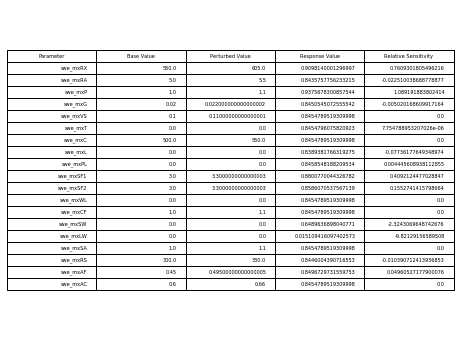

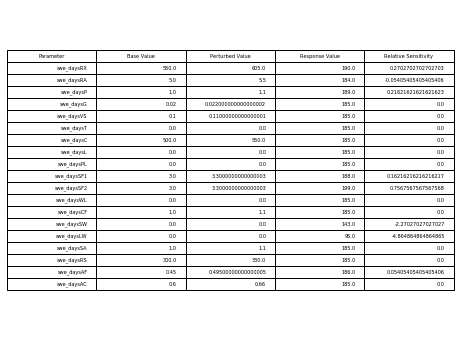

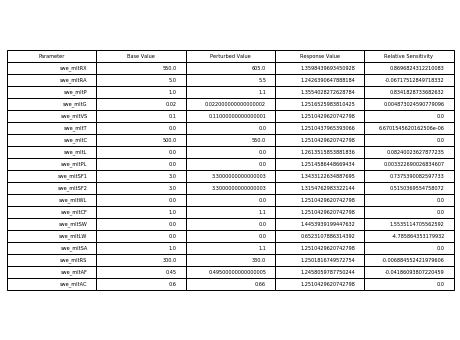

In [36]:
#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_mx.values,colLabels=df_mx.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEmx_OR1.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_days.values,colLabels=df_days.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEdays_OR1.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_mlt.values,colLabels=df_mlt.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEmlt_OR1.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

In [37]:
#snowtran off OR
## Generate sensitivity table - rows are parameters, 
#columns are sensitivity results

# rho_mx parameter
results_swe_mxRX = Sensitive(swe_mxB,'swe_mxRX',swe_mxRX,rho_mx_base)
results_swe_daysRX = Sensitive(swe_daysB,'swe_daysRX',swe_daysRX,rho_mx_base)
results_swe_mltRX = Sensitive(swe_mltB,'swe_mltRX',swe_mltRX,rho_mx_base)

# rho_adj parameter 
results_swe_mxRA = Sensitive(swe_mxB,'swe_mxRA',swe_mxRA,rho_adj_base)
results_swe_daysRA = Sensitive(swe_daysB,'swe_daysRA',swe_daysRA,rho_adj_base)
results_swe_mltRA = Sensitive(swe_mltB,'swe_mltRA',swe_mltRA,rho_adj_base)

# pcor parameter 
results_swe_mxP = Sensitive(swe_mxB,'swe_mxP',swe_mxP,pcor_base[1])
results_swe_daysP = Sensitive(swe_daysB,'swe_daysP',swe_daysP,pcor_base[1])
results_swe_mltP = Sensitive(swe_mltB,'swe_mltP',swe_mltP,pcor_base[1])

# gap_frac parameter
results_swe_mxG = Sensitive(swe_mxB,'swe_mxG',swe_mxG,gap_frac_base)
results_swe_daysG = Sensitive(swe_daysB,'swe_daysG',swe_daysG,gap_frac_base)
results_swe_mltG = Sensitive(swe_mltB,'swe_mltG',swe_mltG,gap_frac_base)

# veg_shd parameter
results_swe_mxVS = Sensitive(swe_mxB,'swe_mxVS',swe_mxVS,veg_shd_base)
results_swe_daysVS = Sensitive(swe_daysB,'swe_daysVS',swe_daysVS,veg_shd_base)
results_swe_mltVS = Sensitive(swe_mltB,'swe_mltVS',swe_mltVS,veg_shd_base)

# snowtran_base 
results_swe_mxT = Sensitive(swe_mxB,'swe_mxT',swe_mxT,snowtran_base)
results_swe_daysT = Sensitive(swe_daysB,'swe_daysT',swe_daysT,snowtran_base)
results_swe_mltT = Sensitive(swe_mltB,'swe_mltT',swe_mltT,snowtran_base)

# curvelen_base 
results_swe_mxC = Sensitive(swe_mxB,'swe_mxC',swe_mxC,curvelen_base)
results_swe_daysC = Sensitive(swe_daysB,'swe_daysC',swe_daysC,curvelen_base)
results_swe_mltC = Sensitive(swe_mltB,'swe_mltC',swe_mltC,curvelen_base)

# lapse_base
results_swe_mxL = Sensitive(swe_mxB,'swe_mxL',swe_mxL,lapse_base)
results_swe_daysL = Sensitive(swe_daysB,'swe_daysL',swe_daysL,lapse_base)
results_swe_mltL = Sensitive(swe_mltB,'swe_mltL',swe_mltL,lapse_base)

# prec_lapse_base 
results_swe_mxPL = Sensitive(swe_mxB,'swe_mxPL',swe_mxPL,prec_lapse_base)
results_swe_daysPL = Sensitive(swe_daysB,'swe_daysPL',swe_daysPL,prec_lapse_base)
results_swe_mltPL = Sensitive(swe_mltB,'swe_mltPL',swe_mltPL,prec_lapse_base)

# snow_frac_base1
results_swe_mxSF1 = Sensitive(swe_mxB,'swe_mxSF1',swe_mxSF1,snow_frac_base)
results_swe_daysSF1 = Sensitive(swe_daysB,'swe_daysSF1',swe_daysSF1,snow_frac_base)
results_swe_mltSF1 = Sensitive(swe_mltB,'swe_mltSF1',swe_mltSF1,snow_frac_base)

# snow_frac_base2
results_swe_mxSF2 = Sensitive(swe_mxB,'swe_mxSF2',swe_mxSF2,snow_frac_base)
results_swe_daysSF2 = Sensitive(swe_daysB,'swe_daysSF2',swe_daysSF2,snow_frac_base)
results_swe_mltSF2 = Sensitive(swe_mltB,'swe_mltSF2',swe_mltSF2,snow_frac_base)

# wind_lapse_base
results_swe_mxWL = Sensitive(swe_mxB,'swe_mxWL',swe_mxWL,wind_lapse_base)
results_swe_daysWL = Sensitive(swe_daysB,'swe_daysWL',swe_daysWL,wind_lapse_base)
results_swe_mltWL = Sensitive(swe_mltB,'swe_mltWL',swe_mltWL,wind_lapse_base)

# cloud_frac_base
results_swe_mxCF = Sensitive(swe_mxB,'swe_mxCF',swe_mxCF,cloud_frac_base)
results_swe_daysCF = Sensitive(swe_daysB,'swe_daysCF',swe_daysCF,cloud_frac_base)
results_swe_mltCF = Sensitive(swe_mltB,'swe_mltCF',swe_mltCF,cloud_frac_base)

# shortwave_base
results_swe_mxSW = Sensitive(swe_mxB,'swe_mxSW',swe_mxSW,shortwave_base)
results_swe_daysSW = Sensitive(swe_daysB,'swe_daysSW',swe_daysSW,shortwave_base)
results_swe_mltSW = Sensitive(swe_mltB,'swe_mltSW',swe_mltSW,shortwave_base)

# longwave_base
results_swe_mxLW = Sensitive(swe_mxB,'swe_mxLW',swe_mxLW,longwave_base)
results_swe_daysLW = Sensitive(swe_daysB,'swe_daysLW',swe_daysLW,longwave_base)
results_swe_mltLW = Sensitive(swe_mltB,'swe_mltLW',swe_mltLW,longwave_base)

# slope_adjust_base 
results_swe_mxSA = Sensitive(swe_mxB,'swe_mxSA',swe_mxSA,slope_adjust_base)
results_swe_daysSA = Sensitive(swe_daysB,'swe_daysSA',swe_daysSA,slope_adjust_base)
results_swe_mltSA = Sensitive(swe_mltB,'swe_mltSA',swe_mltSA,slope_adjust_base)

# ro_snow_base
results_swe_mxRS = Sensitive(swe_mxB,'swe_mxRS',swe_mxRS,ro_snow_base)
results_swe_daysRS = Sensitive(swe_daysB,'swe_daysRS',swe_daysRS,ro_snow_base)
results_swe_mltRS = Sensitive(swe_mltB,'swe_mltRS',swe_mltRS,ro_snow_base)

# albedo_forest_base 
results_swe_mxAF = Sensitive(swe_mxB,'swe_mxAF',swe_mxAF,albedo_forest_base)
results_swe_daysAF = Sensitive(swe_daysB,'swe_daysAF',swe_daysAF,albedo_forest_base)
results_swe_mltAF = Sensitive(swe_mltB,'swe_mltAF',swe_mltAF,albedo_forest_base)

# albedo_clear_base
results_swe_mxAC = Sensitive(swe_mxB,'swe_mxAC',swe_mxAC,albedo_clear_base)
results_swe_daysAC = Sensitive(swe_daysB,'swe_daysAC',swe_daysAC,albedo_clear_base)
results_swe_mltAC = Sensitive(swe_mltB,'swe_mltAC',swe_mltAC,albedo_clear_base)

#SWE max
# make a dataframe to hold the results
records = [ results_swe_mxRX,results_swe_mxRA, results_swe_mxP, results_swe_mxG,results_swe_mxVS, results_swe_mxT,
           results_swe_mxC, results_swe_mxL, results_swe_mxPL, results_swe_mxSF1,results_swe_mxSF2, results_swe_mxWL, results_swe_mxCF,
           results_swe_mxSW, results_swe_mxLW, results_swe_mxSA, results_swe_mxRS, results_swe_mxAF, results_swe_mxAC,
           results_swe_daysRX, results_swe_daysRA,results_swe_daysP, results_swe_daysG,results_swe_daysVS,results_swe_daysT,
           results_swe_daysC, results_swe_daysL, results_swe_daysPL, results_swe_daysSF1,results_swe_daysSF2, results_swe_daysWL, results_swe_daysCF,
           results_swe_daysSW, results_swe_daysLW, results_swe_daysSA, results_swe_daysRS, results_swe_daysAF, results_swe_daysAC,
           results_swe_mltRX, results_swe_mltRA, results_swe_mltP, results_swe_mltG, results_swe_mltVS, results_swe_mltT,
           results_swe_mltC, results_swe_mltL, results_swe_mltPL, results_swe_mltSF1,results_swe_mltSF2, results_swe_mltWL, results_swe_mltCF,
           results_swe_mltSW, results_swe_mltLW, results_swe_mltSA, results_swe_mltRS, results_swe_mltAF, results_swe_mltAC]
labels = ['Parameter', 'Base Value', 'Perturbed Value', 'Response Value', 'Absolute Sensitivity', 'Relative Sensitivity']
df = pd.DataFrame.from_records(records, columns=labels)

df

<ipython-input-7-e0a22523f4c4>:2: RuntimeWarning: divide by zero encountered in true_divide
  absSensitivity = (Rp-Rb)/(rescaleValue*base)
<ipython-input-7-e0a22523f4c4>:2: RuntimeWarning: invalid value encountered in true_divide
  absSensitivity = (Rp-Rb)/(rescaleValue*base)


,Parameter,Base Value,Perturbed Value,Response Value,Absolute Sensitivity,Relative Sensitivity
0,swe_mxRX,550.00,605.000,0.909814,0.001170,0.760930
1,swe_mxRA,5.00,5.500,0.843576,-0.003806,-0.022510
2,swe_mxP,1.00,1.100,0.937568,0.920889,1.089192
3,swe_mxG,0.02,0.022,0.845055,-0.212222,-0.005020
4,swe_mxVS,0.10,0.110,0.845479,0.000000,0.000000
5,swe_mxT,0.00,0.000,0.845480,inf,0.000008
6,swe_mxC,500.00,550.000,0.845479,0.000000,0.000000
7,swe_mxL,0.00,0.000,0.838938,-inf,-0.077362
8,swe_mxPL,0.00,0.000,0.845855,inf,0.004446
9,swe_mxSF1,3.00,3.300,0.880077,0.115327,0.409212


In [ ]:
#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_mx.values,colLabels=df_mx.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEmx_OR.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_days.values,colLabels=df_days.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEdays_OR.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(8,6))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_mlt.values,colLabels=df_mlt.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("SWEmlt_OR.pdf")
pp.savefig(fig, bbox_inches='tight', dpi=300, quality = 90)
pp.close()

In [47]:
import subprocess

df_mx = df[0:19]
df_mx = df_mx.drop("Absolute Sensitivity", axis=1)
df_mx = df_mx.drop("Perturbed Value", axis=1)
df_days = df[19:38]
df_days = df_days.drop("Absolute Sensitivity", axis=1)
df_days = df_days.drop("Perturbed Value", axis=1)
df_mlt = df[38:57]
df_mlt = df_mlt.drop("Absolute Sensitivity", axis=1)
df_mlt = df_mlt.drop("Perturbed Value", axis=1)


filename = 'out.tex'
pdffile = 'out.pdf'
outname = 'out.png'

template = r'''\documentclass[preview]{{standalone}}
\usepackage{{booktabs}}
\begin{{document}}
{}
\end{{document}}
'''

with open(filename, 'wb') as f:
    f.write(bytes(template.format(df_mlt.to_latex()),'UTF-8'))

subprocess.call(['pdflatex', filename])
subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])

0